In [1]:
"""Align crop images for Changhui and Jie's experiment data using the confocol
Use the gfp signal to preselect the in focus images 
"""
%matplotlib inline
from skimage.morphology import remove_small_objects
from scipy import stats
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.patches as mpatches
from scipy.stats import linregress
import scipy.stats
import scipy.signal
import scipy.spatial
import pandas as pd
import numpy as np
import math, re, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from datetime import datetime
from skimage import filters
import skimage, skimage.io, skimage.feature
from skimage.feature import register_translation
from skimage.filters import roberts, sobel, scharr, prewitt
#from skimage.feature.register_translation import _upsampled_dft

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import glob
#from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture

from skimage.measure import label, regionprops
#so the font can be handle by illustrator
mpl.rcParams['pdf.fonttype'] = 42
plt.style.use('ggplot')
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology
from scipy import ndimage as ndi

from skimage.measure import find_contours

In [2]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

print('device used {}'.format(device))

device used cpu


In [3]:
### using UNET and Watershed to segment cells 
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import morphology


def watershedmask(mask, nucleus ):
    '''Here I am applying watershed to the outputted model, this will help further seperate cells that may be 
    super close to each other or any other mother cell'''
    distance = ndimage.distance_transform_edt(nucleus)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((5, 5)), labels= mask)
    markers = morphology.label(local_maxi)
    mask = watershed(-distance, markers, mask=mask)
    #mask = morphology.remove_small_objects(labels, min_size=50)
    return mask

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
from sklearn import mixture

def gausmix( mask):
    """This is to calculate the GFP max using Gaussian mixture model,
    df will be your aligned GFP or RFP followed by the mask which will be the maskquant
    Afterwords we pick the highest mean avalible """
    
    X =   mask # turn it into a 2D array but really 1D 806, 1 example
    gmm = mixture.GaussianMixture(n_components=2).fit(X) 
    maxgmm = np.max(gmm.means_)
    mingmm = np.min(gmm.means_)
    return maxgmm, mingmm  # returns the mixture component greatest min

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#https://theaisummer.com/unet-architectures/

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
    
model = Unet(1,2) # 1 is for how many channels 2 is for how many it outputs i said 2, loading empty model

unetpath = os.getcwd()
name = 'DAPI_UNET_512_512'#'DAPI_UNET_512_512_batch3'# # loading in the model name
model.load_state_dict(torch.load(unetpath+'/{}.pth'.format(name), map_location={'cuda:0': 'cpu'})) # to load model with cpu
model.to(device) # will turn model for GPU or CPU depending on the device stated above


Unet(
  (inc): InConv(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(

In [5]:
### make datafile with the image and filepath
path = os.getcwd()+'/Soledad_lung/'
 
l = []
for file in os.listdir(path):
    if '.ipynb' in file:
        continue
    if file.startswith('16_321') or file.startswith('16_322'):
        age = 'pn5'
    if file.startswith('16_323')  :
        age = '18m'
    if file.startswith('16_324')  :
        age = '13m'
    if file.startswith('16_325') or file.startswith('16_326')  :
        age = '1.5m'
    if file.startswith('16_338') or file.startswith('16_339')  :
        age = '2m'
    if file.startswith('16_340') or file.startswith('16_340')  :
        age = '2weeks'
    passage = file.split(' ')[0]
    character = '_'.join(file.split(' ')[0:3])
 
    l.append({'age':age,'passage':  passage  , 'character': character,'filename': file  ,'filepath': path + '/'+file })

imagedf = pd.DataFrame(l).sort_values('passage', ascending = True)

In [6]:
imagedf.head()

,age,passage,character,filename,filepath
27,pn5,16_321_4_a_-0052.zvi,16_321_4_a_-0052.zvi,16_321_4_a_-0052.zvi,/genomesvr1/home/michael/Hao_li/AgingHallmarks...
45,pn5,16_321_4_a_-0053.zvi,16_321_4_a_-0053.zvi,16_321_4_a_-0053.zvi,/genomesvr1/home/michael/Hao_li/AgingHallmarks...
6,pn5,16_321_4_a_-0054.zvi,16_321_4_a_-0054.zvi,16_321_4_a_-0054.zvi,/genomesvr1/home/michael/Hao_li/AgingHallmarks...
62,pn5,16_321_4_a_-0055.zvi,16_321_4_a_-0055.zvi,16_321_4_a_-0055.zvi,/genomesvr1/home/michael/Hao_li/AgingHallmarks...
63,pn5,16_321_4_a_-0056.zvi,16_321_4_a_-0056.zvi,16_321_4_a_-0056.zvi,/genomesvr1/home/michael/Hao_li/AgingHallmarks...


In [7]:
#imagedf = imagedf.groupby('filename').get_group('16_339_5_b-0026.zvi')

In [8]:
import javabridge
import bioformats as bf
import time as Time
start = Time.time()
cell_properties = []
transform = transforms.ToTensor() # for transformation
javabridge.start_vm(class_path=bf.JARS)

for index in imagedf.index:
    age = imagedf.loc[index, 'age']
    passage = imagedf.loc[index, 'passage']
    name = imagedf.loc[index, 'filename']
    image = bf.load_image(imagedf.loc[index, 'filepath']) # for reading .zvi files 
    nucleus =  image[:,:,image.shape[-1]-1] # dapi seems to be the last image
    filepath = imagedf.loc[index, 'filepath']

    # Normalize the whole nucleus image
    bfimage = (nucleus - np.min(nucleus))/(np.max(nucleus)-np.min(nucleus))
    meanbfimage =   np.mean(bfimage) 
    # Loop through the image sections
    for i in range(0, nucleus.shape[0], 512):
        for j in range(0, nucleus.shape[1], 512):
            # Calculate the actual size of the section
            section_size = (min(i+512, nucleus.shape[0]) - i, min(j+512, nucleus.shape[1]) - j)

            # Extract the nucleus section
            nuc_section = bfimage[i:i+section_size[0], j:j+section_size[1]]

            # Calculate padding needed
            padding = ((0, 512 - section_size[0]), (0, 512 - section_size[1]))

            # Apply padding
            padded_section = np.pad(nuc_section, padding, mode='constant', constant_values=0)

            bftensor = transform(padded_section.astype(np.float32))

            # Prediction
            with torch.no_grad():
                predict = model(bftensor.to(device).view(-1,1, 512,512)).to('cpu').detach().numpy() 
            pred = predict[0,1,:,:].reshape(512,512)

            # Finding contours and creating a mask
            mask = np.zeros((512,512)) 
            contours = find_contours(pred, .01)
            for contour in contours:
                contour[:, 0] = np.clip(contour[:, 0], 0, section_size[0]-1)
                contour[:, 1] = np.clip(contour[:, 1], 0, section_size[1]-1)
                mask[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1 
            mask = ndi.binary_fill_holes(mask)
            mask = label(mask)
            mask = mask * (padded_section > meanbfimage) # to remove any possible added cells by the model 
    
            # Measure the region properties of the label mask
            props = skimage.measure.regionprops_table(mask, properties=('label', 'area', 'eccentricity', 'centroid', 'coords'))
            prop_df = pd.DataFrame(props)
            
            for label_id in prop_df['label'].unique():
                if label_id == 0:
                    continue 

                # Extract the coordinates of the current label
                coords = prop_df.loc[prop_df['label'] == label_id, 'coords'].iloc[0]
                eccentricty = prop_df.loc[prop_df['label'] == label_id, 'eccentricity'].iloc[0]
                # Calculate the coordinates in the original 3072 image
                coords[:, 0] += i
                coords[:, 1] += j

                # Create a mask of the current label within the original section size
                label_mask = (mask[:section_size[0], :section_size[1]] == label_id)

                # Calculate the properties of the current cell
                nucleuspixelsum = np.sum(nuc_section[label_mask])
                nucleusmean = np.mean(nuc_section[label_mask])
                nucleusarea = np.sum(label_mask)

                # Append the cell properties to the list
                cell_name_id = str(label_id) +'_' +name
                cell_properties.append({'age':age, 'cell_name_id': cell_name_id, 'label': label_id, 'name': name, 'passage':passage,
                                        'nucleus_sum':nucleuspixelsum, 'nucleus_mean':nucleusmean, 'nucleus_area':nucleusarea, 'coords': coords, 'eccentricity':eccentricty,'filename':filepath})

# Create a pandas dataframe
df_quant = pd.DataFrame(cell_properties)
 

end = Time.time()

print((end-start)/60, 'minutes to run ')
javabridge.kill_vm()

14:58:08.113 [Thread-0] DEBUG loci.common.NIOByteBufferProvider - Using mapped byte buffer? false
14:58:08.146 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.base/jdk.internal.loader.BuiltinClassLoader.loadClass(BuiltinClassLoader.java:581)
	at java.base/jdk.internal.loader.ClassLoaders$AppClassLoader.loadClass(ClassLoaders.java:178)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:522)
	at java.base/java.lang.Class.forName0(Native Method)
	at java.base/java.lang.Class.forName(Class.java:315)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
14:58:08.151 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
	at java.base/jdk.internal.loader.BuiltinClas

In [9]:
df_quant.to_hdf('soledad_liver_dapix.hdf' ,'df')  

/home/michael/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:2700: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['age', 'cell_name_id', 'name', 'passage', 'coords', 'filename'], dtype='object')]

  pytables.to_hdf(


# Analyzing the Data

In [17]:
df_quant =   pd.read_hdf('soledad_liver_dapi.hdf') #pd.read_hdf('soledad_liver.hdf')
 

In [18]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)

 

In [19]:
df_quant['age'].unique()

array(['pn5', '1.5m', '2m', '2weeks'], dtype=object)

In [34]:
df_quant.loc[df_quant.age == 'pn5','passage'].unique()

array(['16_321_4_a_-0052.zvi', '16_321_4_a_-0053.zvi',
       '16_321_4_a_-0054.zvi', '16_321_4_a_-0055.zvi',
       '16_321_4_a_-0056.zvi', '16_322_5_a_-0042.zvi',
       '16_322_5_a_-0043.zvi', '16_322_5_a_-0044.zvi',
       '16_322_5_a_-0045.zvi', '16_322_5_a_-0046.zvi',
       '16_322_5_b_-0047.zvi', '16_322_5_b_-0048.zvi',
       '16_322_5_b_-0049.zvi', '16_322_5_b_-0050.zvi',
       '16_322_5_b_-0051.zvi'], dtype=object)

In [45]:
dftest = df_quant.groupby('name').get_group('16_322_5_a_-0043.zvi')

In [46]:
image = bf.load_image(dftest['filename'].unique()[0]) # for reading .zvi files 

19:18:52.510 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.base/jdk.internal.loader.BuiltinClassLoader.loadClass(BuiltinClassLoader.java:581)
	at java.base/jdk.internal.loader.ClassLoaders$AppClassLoader.loadClass(ClassLoaders.java:178)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:522)
	at java.base/java.lang.Class.forName0(Native Method)
	at java.base/java.lang.Class.forName(Class.java:315)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
19:18:52.510 [Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.SlideBook6Reader
java.lang.ClassNotFoundException: loci.formats.in.SlideBook6Reader
	at java.base/jdk.internal.loader.BuiltinClassLoader.loadClass(BuiltinClassLoader.java:581)
	at java.base/jdk.internal.loader.ClassLoaders$AppC

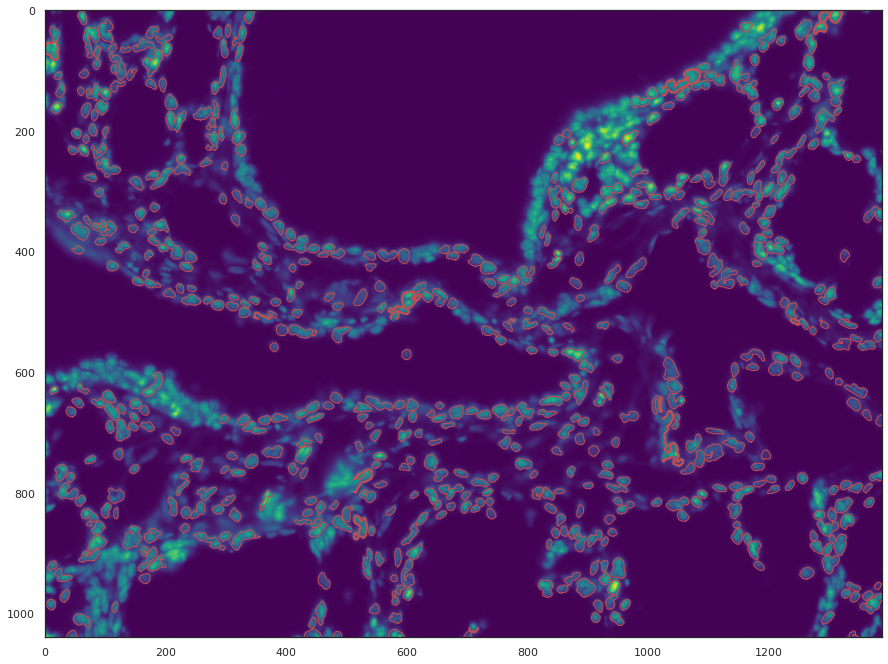

In [47]:
filterdf = dftest  .loc[(dftest['nucleus_area'] > 80)   &(dftest['nucleus_area'] < 700) ]# &(dftest['eccentricity'] < .7)]  #&(dftest['eccentricity'] < .9) 
mask = np.zeros_like(image[:,:, image.shape[2]-1])
 
plt.figure(figsize = (15,15))
for index in filterdf.index:
    coords = filterdf.loc[index, 'coords']
    mask[(coords[:,0] ).astype(int), (coords[:,1] ).astype(int)] = 1

plt.imshow(image[:,:,image.shape[2]-1], cmap = 'viridis')
contours = find_contours(mask, .01)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='r')
 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pn5 v.s. 2weeks: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.232e+06
2weeks v.s. 1.5m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.591e-01 U_stat=1.908e+07
1.5m v.s. 2m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.939e-60 U_stat=7.697e+07
pn5 v.s. 1.5m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.614e+07
2weeks v.s. 2m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.075e-15 U_stat=1.480e+07
pn5 v.s. 2m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.995e-34 U_stat=3.564e+07


Text(0.5, 1.0, 'nucleus_area')

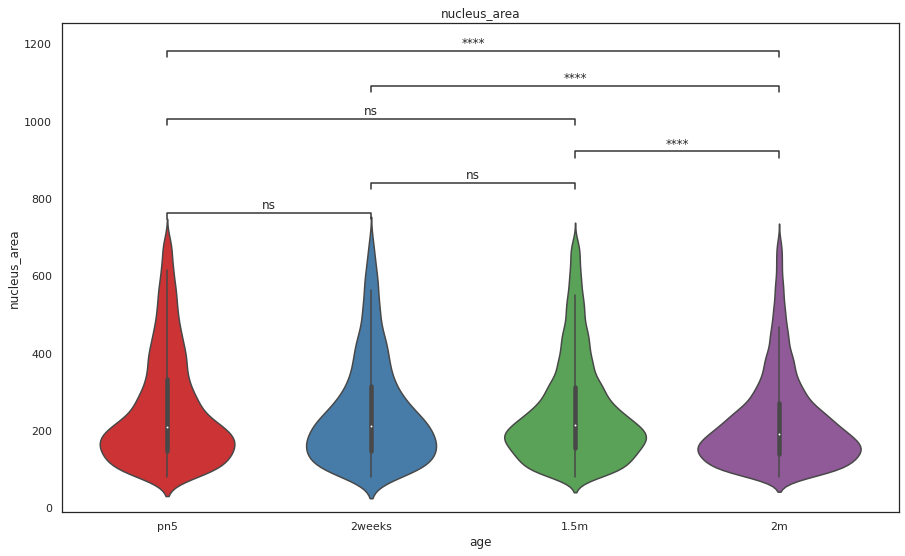

In [40]:
 
from statannot import add_stat_annotation
from itertools import combinations
subj = 'nucleus_area'


testdf = df_quant.loc[(df_quant['nucleus_area'] > 80)   &(df_quant['nucleus_area'] < 700)] # &(df_quant['eccentricity'] < .9)]

#dfilter = testdf.sort_values('age', ascending = False) #.sort_values('passage', ascending = False)
dfilter = testdf.set_index('age').loc[['pn5', '2weeks', '1.5m', '2m'  ]].reset_index()
sns.set_theme(style='white')
sns.set_palette('deep')
f, ax = plt.subplots(1, figsize = (15,9))
sns.violinplot(x = 'age', y = subj, ax = ax, data = dfilter, palette="Set1")

# get all unique values
unique_passages = dfilter['age'].unique()

# get all combinations of these unique values
box_pairs = list(combinations(unique_passages, 2))

# then use box_pairs in your function call
add_stat_annotation(ax, data  =dfilter, x='age', y=subj, 
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.title(subj)
 
#plt.savefig('Soledad_Aged_Violin_Liver.pdf' )

In [41]:
for age in testdf['age'].unique():
    print(f'{age} =  {sum(testdf.age == age)}')

pn5 =  6591
1.5m =  14081
2m =  9716
2weeks =  2763


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pn5 v.s. 1.5m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.940e-32 U_stat=1.794e+07
1.5m v.s. 2m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.305e-60 U_stat=3.384e+07
2m v.s. 2weeks: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.629e-12 U_stat=4.781e+06
pn5 v.s. 2m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.729e-01 U_stat=1.333e+07
1.5m v.s. 2weeks: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.064e-02 U_stat=8.823e+06
pn5 v.s. 2weeks: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.252e-06 U_stat=3.459e+06


Text(0.5, 1.0, 'nucleus_area')

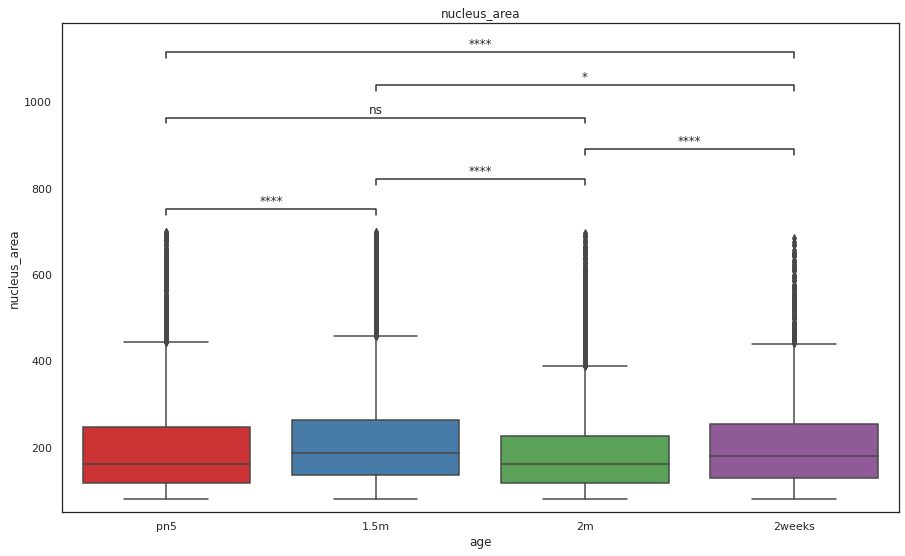

In [26]:
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations
subj = 'nucleus_area'


testdf = df_quant.loc[(df_quant['nucleus_area'] > 80)   &(df_quant['nucleus_area'] < 700) &(df_quant['eccentricity'] < .88)]
 
dfilter = testdf.sort_values('nucleus_area', ascending = False) #.sort_values('passage', ascending = False)
sns.set_theme(style='white')
f, ax = plt.subplots(1, figsize = (15,9))
sns.boxplot(x = 'age', y = subj, ax = ax,data = dfilter   ,palette="Set1")

 
 
# get all unique values
unique_passages = dfilter['age'].unique()

# get all combinations of these unique values
box_pairs = list(combinations(unique_passages, 2))

# then use box_pairs in your function call
add_stat_annotation(ax, data  =dfilter, x='age', y=subj, 
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#sns.swarmplot(x = 'passage', y = subj, data = df_quant , color = '.25' )
plt.title(subj)

#plt.savefig('Diana_Aged_Liver.pdf' )